# Assignment 6

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from utils.load_model import ModelCL
from utils.test_loop import test_loop
from utils.train_loop import train_loop
from utils.load_data import load_dataset, create_samplers


%matplotlib inline
sns.set_style('darkgrid')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed(69)


################################
## CONFIG
################################
DATASET_NAME = "mnist"
DATASET_ROOT_PATH = f"./../data/{DATASET_NAME}/"
NUM_CLASSES = 10


BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.01


# SET GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nWe're using =>", device)


################################
## LOAD DATASET
################################

image_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
    "test": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
}

# datasets
train_dataset = load_dataset(
    dataset_name=DATASET_NAME,
    dataset_root_path=DATASET_ROOT_PATH,
    is_train=True,
    image_transforms=image_transforms["train"],
)

test_dataset = load_dataset(
    dataset_name=DATASET_NAME,
    dataset_root_path=DATASET_ROOT_PATH,
    is_train=False,
    image_transforms=image_transforms["test"],
)

# train-val sampler
train_sampler, val_sampler = create_samplers(train_dataset, 0.8)


# dataloader
train_loader = DataLoader(
    dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=train_sampler,
)

val_loader = DataLoader(
    dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=val_sampler
)

test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

## Data Sanity Check
print(f"\nTrain loader = {next(iter(train_loader))[0].shape}")
print(f"Val loader = {next(iter(val_loader))[0].shape}")
print(f"Test loader = {next(iter(test_loader))[0].shape}")
print(f"\nTrain loader length = {len(train_loader)}")
print(f"Val loader length = {len(val_loader)}")

print(f"Test loader length = {len(test_loader)}")


We're using => cuda

Train loader = torch.Size([128, 1, 28, 28])
Val loader = torch.Size([128, 1, 28, 28])
Test loader = torch.Size([128, 1, 28, 28])

Train loader length = 375
Val loader length = 94
Test loader length = 79


## Batch Norm


Begin training.


Epoch 01/20: | Train Loss: 0.53510 | Val Loss: 0.15106 | Train Acc: 82.693% | Val Acc: 95.723%
Epoch 02/20: | Train Loss: 0.08574 | Val Loss: 0.06429 | Train Acc: 97.280% | Val Acc: 98.000%
Epoch 03/20: | Train Loss: 0.05671 | Val Loss: 0.05443 | Train Acc: 98.131% | Val Acc: 98.191%
Epoch 04/20: | Train Loss: 0.04433 | Val Loss: 0.04719 | Train Acc: 98.429% | Val Acc: 98.383%
Epoch 05/20: | Train Loss: 0.03954 | Val Loss: 0.04185 | Train Acc: 98.616% | Val Acc: 98.574%
Epoch 06/20: | Train Loss: 0.03075 | Val Loss: 0.03466 | Train Acc: 98.872% | Val Acc: 98.755%
Epoch 07/20: | Train Loss: 0.02851 | Val Loss: 0.03536 | Train Acc: 98.917% | Val Acc: 98.681%
Epoch 08/20: | Train Loss: 0.02721 | Val Loss: 0.03783 | Train Acc: 99.037% | Val Acc: 98.713%
Epoch 09/20: | Train Loss: 0.02583 | Val Loss: 0.03495 | Train Acc: 99.072% | Val Acc: 98.777%
Epoch 10/20: | Train Loss: 0.02622 | Val Loss: 0.03598 | Train Acc: 99.003% | Val Acc: 98.660%
Epoch 11/20: | Train Loss: 0.02545 | Val Loss: 0.0


Test Accuracy = 0.9925



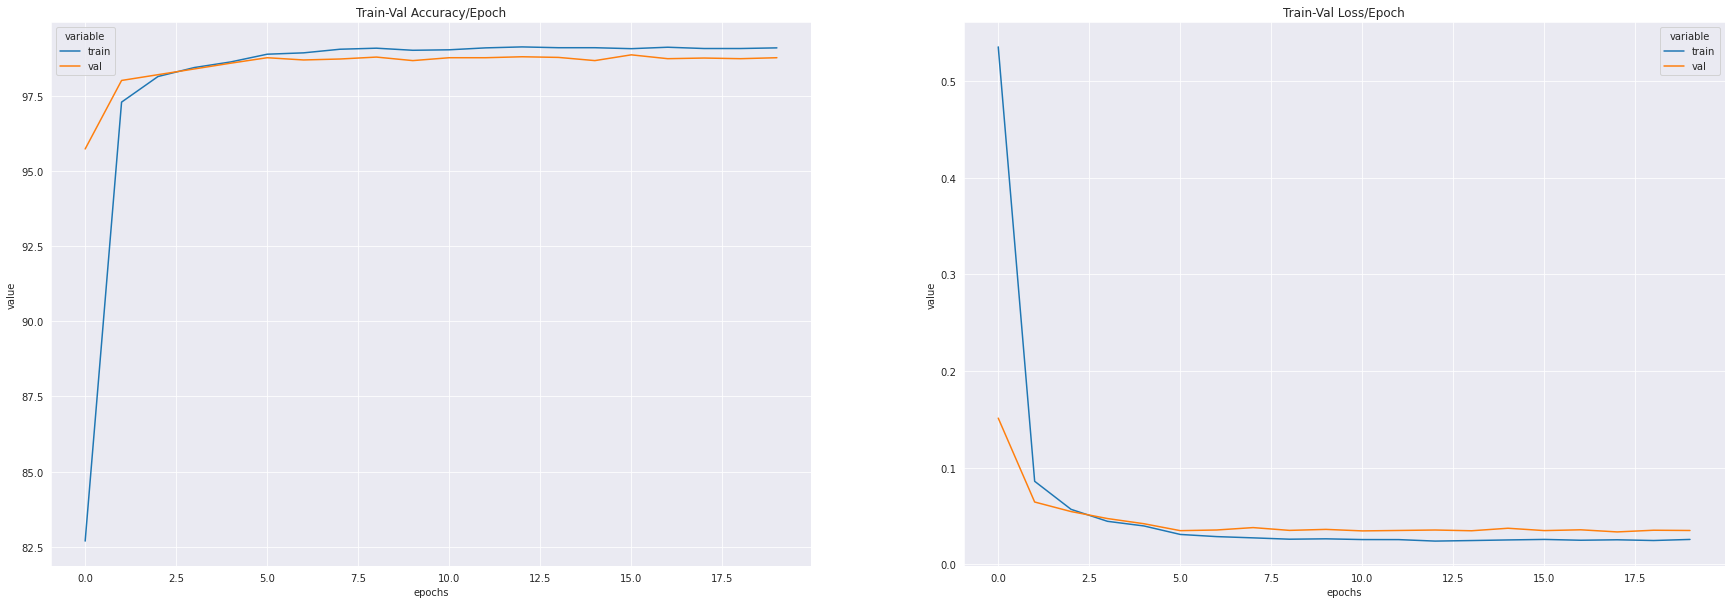

In [2]:
################################
## LOAD MODEL
################################
model = ModelCL(num_classes=NUM_CLASSES, norm_type="bnorm")

x_train_example, y_train_example = next(iter(train_loader))
y_pred_example = model(x_train_example)

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


################################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


train_val_acc_df = pd.DataFrame.from_dict(acc_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)


print(f"Test Accuracy = {accuracy_score(y_true_list, y_pred_list)}\n")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


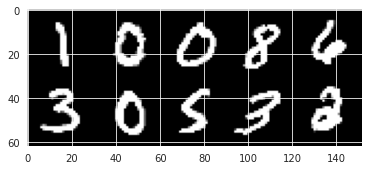

In [3]:
misclassified_idx = [i for i,(pred,actual) in enumerate(zip(y_pred_list, y_true_list)) if pred != actual]
misclassified_img = torch.stack([train_dataset[i][0] for i in misclassified_idx], dim=0)
grid_img= torchvision.utils.make_grid(misclassified_img[:10], nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))

## Group Norm


Begin training.


Epoch 01/20: | Train Loss: 0.83007 | Val Loss: 0.20482 | Train Acc: 73.349% | Val Acc: 94.160%
Epoch 02/20: | Train Loss: 0.14468 | Val Loss: 0.09439 | Train Acc: 95.683% | Val Acc: 97.085%
Epoch 03/20: | Train Loss: 0.10438 | Val Loss: 0.08236 | Train Acc: 96.843% | Val Acc: 97.489%
Epoch 04/20: | Train Loss: 0.07384 | Val Loss: 0.07855 | Train Acc: 97.664% | Val Acc: 97.564%
Epoch 05/20: | Train Loss: 0.06773 | Val Loss: 0.10071 | Train Acc: 97.851% | Val Acc: 96.840%
Epoch 06/20: | Train Loss: 0.04815 | Val Loss: 0.05223 | Train Acc: 98.416% | Val Acc: 98.255%
Epoch 07/20: | Train Loss: 0.04007 | Val Loss: 0.05268 | Train Acc: 98.611% | Val Acc: 98.298%
Epoch 08/20: | Train Loss: 0.03914 | Val Loss: 0.04884 | Train Acc: 98.667% | Val Acc: 98.372%
Epoch 09/20: | Train Loss: 0.03775 | Val Loss: 0.04952 | Train Acc: 98.691% | Val Acc: 98.415%
Epoch 10/20: | Train Loss: 0.03633 | Val Loss: 0.04715 | Train Acc: 98.733% | Val Acc: 98.436%
Epoch 11/20: | Train Loss: 0.03424 | Val Loss: 0.0


Test Accuracy = 0.9899



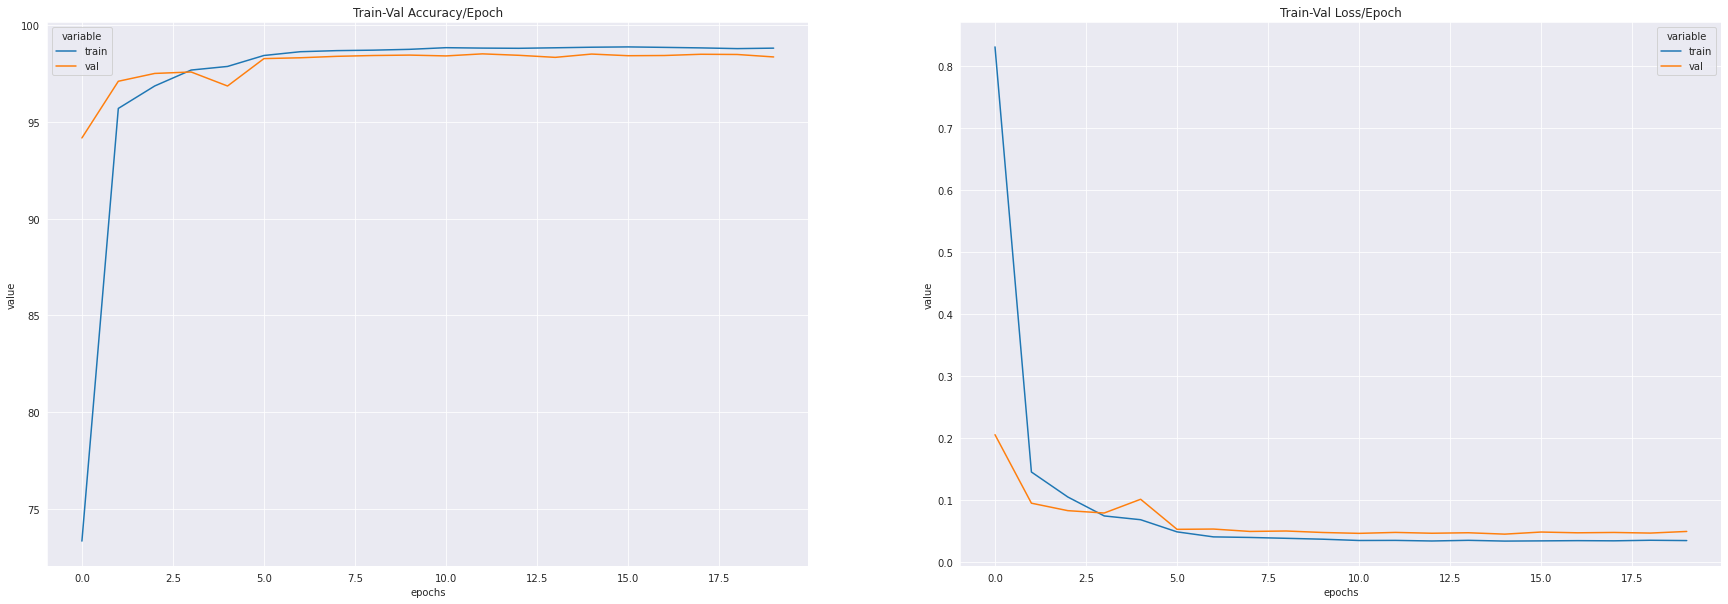

In [4]:
################################
## LOAD MODEL
################################
model = ModelCL(num_classes=NUM_CLASSES, norm_type="gnorm")

x_train_example, y_train_example = next(iter(train_loader))
y_pred_example = model(x_train_example)

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


################################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


train_val_acc_df = pd.DataFrame.from_dict(acc_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)


print(f"Test Accuracy = {accuracy_score(y_true_list, y_pred_list)}\n")
# print("=" * 50)
# print(f"Classification Report: \n\n {classification_report(y_true_list, y_pred_list)}")
# print("=" * 50)
# print(f"Confusion Matrix: \n\n {confusion_matrix(y_true_list, y_pred_list)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


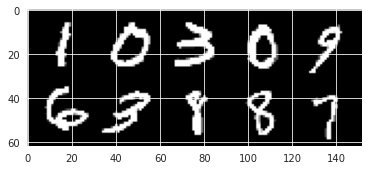

In [5]:
misclassified_idx = [i for i,(pred,actual) in enumerate(zip(y_pred_list, y_true_list)) if pred != actual]
misclassified_img = torch.stack([train_dataset[i][0] for i in misclassified_idx], dim=0)
grid_img= torchvision.utils.make_grid(misclassified_img[:10], nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))

## Layer Norm


Begin training.


Epoch 01/20: | Train Loss: 0.94659 | Val Loss: 0.35824 | Train Acc: 68.664% | Val Acc: 89.532%
Epoch 02/20: | Train Loss: 0.24014 | Val Loss: 0.18216 | Train Acc: 92.885% | Val Acc: 94.511%
Epoch 03/20: | Train Loss: 0.15668 | Val Loss: 0.13847 | Train Acc: 95.267% | Val Acc: 96.138%
Epoch 04/20: | Train Loss: 0.12699 | Val Loss: 0.12189 | Train Acc: 96.200% | Val Acc: 96.479%
Epoch 05/20: | Train Loss: 0.10631 | Val Loss: 0.10650 | Train Acc: 96.765% | Val Acc: 96.819%
Epoch 06/20: | Train Loss: 0.07679 | Val Loss: 0.07634 | Train Acc: 97.608% | Val Acc: 97.702%
Epoch 07/20: | Train Loss: 0.06986 | Val Loss: 0.07401 | Train Acc: 97.771% | Val Acc: 97.723%
Epoch 08/20: | Train Loss: 0.06587 | Val Loss: 0.07142 | Train Acc: 97.909% | Val Acc: 97.894%
Epoch 09/20: | Train Loss: 0.06628 | Val Loss: 0.07178 | Train Acc: 97.907% | Val Acc: 97.883%
Epoch 10/20: | Train Loss: 0.06333 | Val Loss: 0.07185 | Train Acc: 97.979% | Val Acc: 97.745%
Epoch 11/20: | Train Loss: 0.06296 | Val Loss: 0.0


Test Accuracy = 0.9827



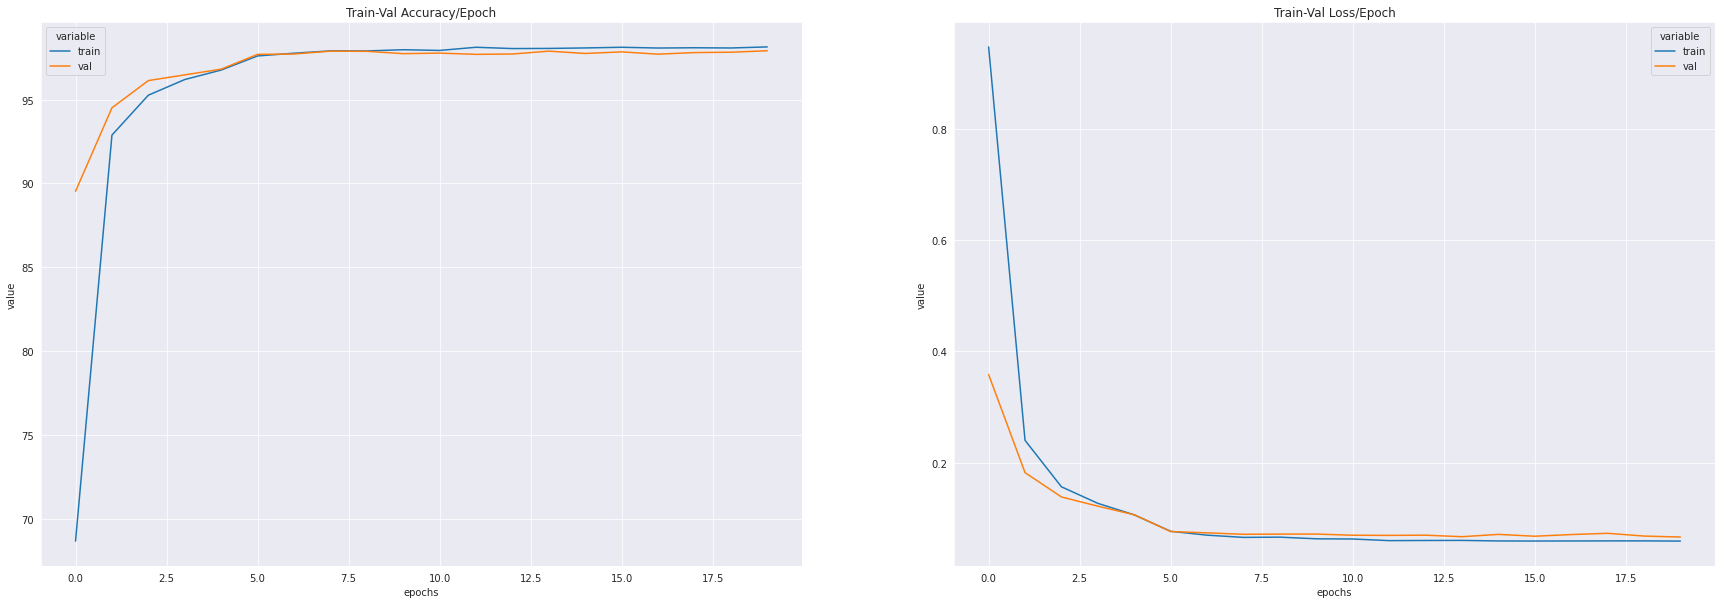

In [6]:
################################
## LOAD MODEL
################################
model = ModelCL(num_classes=NUM_CLASSES, norm_type="lnorm")

x_train_example, y_train_example = next(iter(train_loader))
y_pred_example = model(x_train_example)

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


################################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


train_val_acc_df = pd.DataFrame.from_dict(acc_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)


print(f"Test Accuracy = {accuracy_score(y_true_list, y_pred_list)}\n")
# print("=" * 50)
# print(f"Classification Report: \n\n {classification_report(y_true_list, y_pred_list)}")
# print("=" * 50)
# print(f"Confusion Matrix: \n\n {confusion_matrix(y_true_list, y_pred_list)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


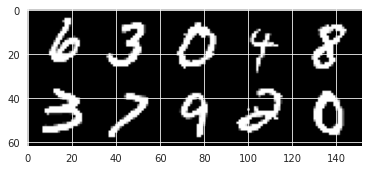

In [7]:
misclassified_idx = [i for i,(pred,actual) in enumerate(zip(y_pred_list, y_true_list)) if pred != actual]
misclassified_img = torch.stack([train_dataset[i][0] for i in misclassified_idx], dim=0)
grid_img= torchvision.utils.make_grid(misclassified_img[:10], nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))